In [3]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import time

In [5]:
# You don't need to understand this function for now.
def load_data_CIFAR10(batch_size, resize=None):
    """Download the CIFAR10 dataset and then load it into memory."""
    trans = [torchvision.transforms.ToTensor()]
    if resize:
        trans.insert(0, torchvision.transforms.Resize(resize))
    trans = torchvision.transforms.Compose(trans)
    mnist_train = torchvision.datasets.CIFAR10(
        root="./data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.CIFAR10(
        root="./data", train=False, transform=trans, download=True)
    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=2))

In [6]:
batch_size = 128 # Defines the batch size
train_iter, test_iter = load_data_CIFAR10(batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
X, y = next(iter(train_iter)) # Requests the first training batch
print(X.size()) # 256 images per batch. Each image is represented by a 1 x 28 x 28 tensor (number of channels x height x width). The images are grayscale, so there is a single channel.
print(y.size())

torch.Size([128, 3, 32, 32])
torch.Size([128])


## Intermediate Block Generator

for creating each intermediate block a class has been definied. This class get the number of convolutional layers, and its layers and parameters.

In [8]:
# class BlockGen(nn.Module):
#     # Creating Intermediate Blocks
#     # the length of param indicates the number of intermediate blocks
#     # each parameter is then inside the param for convolutional layers
#     def __init__(self, in_channels, out_channels, c, layers, paddings, strides, kernels):
#         super(BlockGen, self).__init__()
#         self.relu = nn.ReLU()
#         master_model = nn.ModuleList([])
#         self.c = c
#         self.layers = layers
#         for i in range(c):
#             convs = nn.ModuleList()
#             for j in range(layers[i]):
#                 convs.append(nn.Conv2d(in_channels[i][j], out_channels[i][j], kernel_size=kernels[i][j],stride= 1, padding= 'same'))
#             master_model.append(convs)
#         self.model = master_model
#         # the fully-connected layer turning m to a to calculate the weights of convolutional layer in the final equation the output should be the same value as the number of concolutional layers
#         self.fc = nn.Linear(in_channels[0][0], c)
#         self.batchnorm2d = nn.BatchNorm2d(out_channels[i][j])
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1)
#         self.dropout = nn.Dropout(0.2)

#     def forward(self, x):
#         m = torch.mean(torch.flatten(x, 2), dim=2)
#         a = self.fc(m)
#         model = self.model
#         out_list = []
#         for i, mod in enumerate(model):
#             out_list.append(0)
#             weight = a[:, i].unsqueeze(1).unsqueeze(2).unsqueeze(3)
#             out = x
#             for model in mod:
#                 out = model(out)

#             out_list[i] =  weight * self.maxpool(out)

#         output = torch.tensor(sum(out_list))
#         return self.dropout(self.relu(self.batchnorm2d(output)))


In [9]:
class BlockGen(nn.Module):
    # Creating Intermediate Blocks
    # the length of param indicates the number of intermediate blocks
    # each parameter is then inside the param for convolutional layers
    def __init__(self, in_channels, out_channels, kernels, c):
        super(BlockGen, self).__init__()
        self.relu = nn.ReLU()

        self.layers = layers
        for i in range(c):
            convs = nn.ModuleList()
            convs.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernels,stride= 1, padding= 'same'))

        self.model = convs
        # the fully-connected layer turning m to a to calculate the weights of convolutional layer in the final equation the output should be the same value as the number of concolutional layers
        self.fc = nn.Linear(in_channels[0][0], c)
        self.batchnorm2d = nn.BatchNorm2d(out_channels[i])
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        m = torch.mean(torch.flatten(x, 2), dim=2)
        a = self.fc(m)
        model = self.model
        out_list = []
        for i, mod in enumerate(model):
            out_list.append(0)
            weight = a[:, i].unsqueeze(1).unsqueeze(2).unsqueeze(3)
            out = x
            for model in mod:
                out = model(out)

            out_list[i] =  weight * self.maxpool(out)

        output = torch.tensor(sum(out_list))
        return self.dropout(self.relu(self.batchnorm2d(output)))


In [10]:
class FinalModel(nn.Module):
    # Creating Intermediate Blocks
    # the length of param indicates the number of intermediate blocks
    # each parameter is then inside the param for convolutional layers
    def __init__(self, num_block, c, in_channels, out_channels, kernels):
        super(FinalModel, self).__init__()
        blocks = nn.ModuleList([])
        for i in range(num_block):
            blocks.append(BlockGen(in_channels=in_channels[i], out_channels=out_channels[i], kernels=kernels, c=c[i]))
            # print('block done')
        self.blocks = blocks
        self.fc1 = nn.Linear(out_channels[-1], 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        # creating the convolutional neurons in the layer of the block
        out_list = nn.ModuleList([])
        for model in self.blocks:
            x = model(x)

        channel_avg = torch.mean(torch.flatten(x, 2), dim=2)
        out = self.fc1(channel_avg)
        out = self.fc2(out)

        return out

Defining parameters

In [11]:
num_blocks = 5
c = [15,15,15,15,15]
kernels = [5,5,7,5,6,5,5,5,4,4,4,3,3,3,1]
# paddings = [[[2,0,0],[0,0]],[[2,0],[1,0]],[['same']],[['same'],['same']]]
# strides = [[[1,2,1],[2,1],[1],[1]], [[1,1],[1,1]], [[1]],[[1],[1]]]
in_channels = [3,8,16,32,64]
out_channels = [8,16,32,64,128]

In [137]:
# num_blocks = 5
# c = [1,1,1,1,1]
# layers = [[15],[15],[15],[15],[15]]
# kernels = [[[5]],[[6]],[[7]],[[4]],[[3]]]
# # paddings = [[[2,0,0],[0,0]],[[2,0],[1,0]],[['same']],[['same'],['same']]]
# # strides = [[[1,2,1],[2,1],[1],[1]], [[1,1],[1,1]], [[1]],[[1],[1]]]
# in_channels = [[[3]],[[8]],[[16]],[[32]],[[64]]]
# out_channels = [[[8]],[[16]],[[32]],[[64]],[[128]]]

In [138]:
# num_blocks = 4
# c = [5, 2, 1, 2]
# layers = [[3, 2, 1, 1, 1], [2, 2], [1], [1, 1]]
# kernels = [[[5,5,3],[4,4],[3],[5],[7]],[[5,3],[3,5]],[[3]],[[3],[5]]]
# # paddings = [[[2,0,0],[0,0]],[[2,0],[1,0]],[['same']],[['same'],['same']]]
# # strides = [[[1,2,1],[2,1],[1],[1]], [[1,1],[1,1]], [[1]],[[1],[1]]]
# in_channels = [[[3,6,16],[3,16],[3],[3],[3]],[[32,64],[32,64]], [[128]],[[256],[256]]]
# out_channels = [[[6,16,32],[16,32],[32],[32],[32]],[[64,128],[64,128]],[[256]],[[512],[512]]]

In [12]:
# Applies Xavier initialization if the `torch.nn.Module` is `torch.nn.Linear` or `torch.nn.Conv2d`
def init_weights(m):
    if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

# num_outputs = 10
model = FinalModel(num_block=num_blocks, c = c, in_channels=in_channels, out_channels=out_channels, kernels= kernels).to(device)
model.apply(init_weights) # Applies `init_weights` to every `torch.nn.Module` inside `model`

NameError: name 'layers' is not defined

In [101]:
# # Applies Xavier initialization if the `torch.nn.Module` is `torch.nn.Linear` or `torch.nn.Conv2d`
# def init_weights(m):
#     if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
#         torch.nn.init.xavier_uniform_(m.weight)

# # num_outputs = 10
# model = FinalModel(num_block=num_blocks, c = c, layers = layers, in_channels=in_channels, out_channels=out_channels, kernels= kernels).to(device)
# model.apply(init_weights) # Applies `init_weights` to every `torch.nn.Module` inside `model`

In [102]:
loss = torch.nn.CrossEntropyLoss()

In [103]:
lr = 0.009
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [104]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

In [105]:
def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = torch.tensor(0.).to(device)
    n = torch.tensor(0.).to(device)
    j = 0
    for X, y in data_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        c += metric(logits, y)
        n += len(y)
    return c*100 / n

In [106]:
model.eval()
print(f'Training accuracy: {evaluate_metric(model, train_iter, correct)}. Testing accuracy: {evaluate_metric(model, test_iter, correct)}.')

/tmp/ipykernel_1862/1535056675.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = torch.tensor(sum(out_list))


Training accuracy: 32.02000045776367. Testing accuracy: 32.41999816894531.


## Training

In [107]:
losses = [] # Stores the loss for each training batch
train_accs = [] # Stores the training accuracy after each epoch
test_accs = [] # Stores the testing accuracy after each epoch

num_epochs = 100
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}.')
    start_time = time.perf_counter()

    model.train() # This is necessary because batch normalization behaves differently between training and evaluation

    for X, y in train_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X) # Computes the logits for the batch of images `X`
        l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
        optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
        l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

        optimizer.step() # Updates the model parameters based on the gradients stored inside them

        losses.append(float(l)) # Stores the loss for this batch

    with torch.no_grad(): # Computing performance metrics does not require gradients
        model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
        train_accs.append(evaluate_metric(model, train_iter, correct))
        test_accs.append(evaluate_metric(model, test_iter, correct))

        end_time = time.perf_counter()

        print(f'Training accuracy: {train_accs[-1]}. Testing accuracy: {test_accs[-1]}. Duration: {end_time - start_time:.3f}s.') # Computes and displays training/testing dataset accuracy.

plt.plot(losses) # Plots the loss for each training batch
plt.xlabel('Training batch')
plt.ylabel('Cross entropy loss')
plt.show()

plt.plot(list(map(lambda x: x.cpu(),train_accs)), label='Training accuracy')
plt.plot(list(map(lambda x: x.cpu(),test_accs)), label='Testing accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.show()


Epoch 1/200.


/tmp/ipykernel_1862/1535056675.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = torch.tensor(sum(out_list))


Training accuracy: 29.441999435424805. Testing accuracy: 29.6200008392334. Duration: 7.649s.

Epoch 2/200.
Training accuracy: 29.621999740600586. Testing accuracy: 30.459999084472656. Duration: 7.598s.

Epoch 3/200.
Training accuracy: 31.104000091552734. Testing accuracy: 31.31999969482422. Duration: 7.651s.

Epoch 4/200.
Training accuracy: 30.562000274658203. Testing accuracy: 31.020000457763672. Duration: 7.622s.

Epoch 5/200.
Training accuracy: 30.507999420166016. Testing accuracy: 30.8799991607666. Duration: 7.725s.

Epoch 6/200.
Training accuracy: 31.027999877929688. Testing accuracy: 31.6200008392334. Duration: 7.625s.

Epoch 7/200.
Training accuracy: 31.43199920654297. Testing accuracy: 31.809999465942383. Duration: 7.684s.

Epoch 8/200.
Training accuracy: 32.040000915527344. Testing accuracy: 32.470001220703125. Duration: 7.638s.

Epoch 9/200.
Training accuracy: 33.082000732421875. Testing accuracy: 33.349998474121094. Duration: 7.643s.

Epoch 10/200.
Training accuracy: 31.7940

KeyboardInterrupt: 

In [ ]:
 plt.plot(train_accs.cpu(), label='Training accuracy')
plt.plot(test_accs.cpu(), label='Testing accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.show()

AttributeError: 'list' object has no attribute 'cpu'

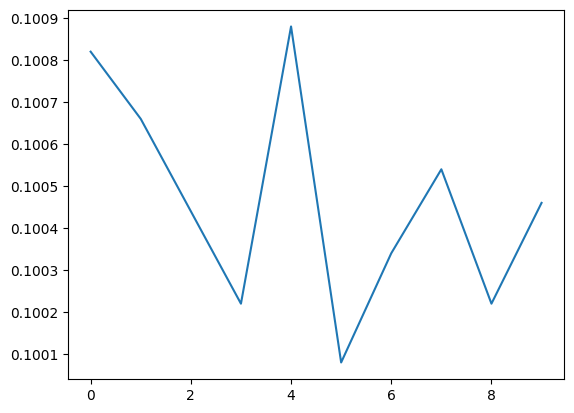

In [ ]:
v = list(map(lambda x: x.cpu(),train_accs))
plt.plot(v, label='Training accuracy')